Date: 25/10/2019

Version: 1.2

Environment: Python 3.7.1 and Anaconda 4.6.14 (64-bit)

**Libraries used:**

* **`pandas 0.25.1`** (for data frame, included in Anaconda Python 3.7) 
* **`re 2.2.1`** (for regular expressions, included in Anaconda Python 3.7) 
* **`shapefile`** (for reading and manipulating shp files)
* **`shapely.geometry.point`** (for creating point objects for data)
* **`geopandas`** (for manipulating polygons and check points within them)
* **`bs4`** (for webscraping using regex and html tags)
* **`numpy`** (for data manipulation on various tasks, included in Anaconda Python 3.7)
* **`matplotlib`** (for creating visuals, included in Anaconda Python 3.7)
* **`math`** (for using trigonometric functions, included in Anaconda Python 3.7)

# INDEX:

## 1. Task 1: (Data Integration)
### 1.1 Introduction
### 1.2 Importing Libraries
### 1.3 Reading files
### 1.4 Visualizing shapefile
### 1.5 Creating columns
#### $\qquad$ 1.5d Column : Suburb
#### $\qquad$ 1.5d Columns : train_station_id, distance_to_train_station
#### $\qquad$ 1.5d Column : travel_min_to_CBD
#### $\qquad$ 1.5d Column : over_priced?
#### $\qquad$ 1.5e Columns: crime_A_average, crime_B_average, crime_C_average
#### $\qquad$ 1.5f School related columns
## Task 2: Standardization

# 1 Task 1: Data Integration

## 1.1 Introduction
The main task of this assignment is data integration. Here we are provided with a variety of files. The data inside these files is very rich and can be integrated to provide some meaningful analysis. The given data must be scrummed before it can used for various modelling tasks. For this we are given geospatial data in a **`shp`** file, we also posses **`gtfs`** data which can provide information of the transit systems of the locality. We have to scrape data from the given webpages to find information about the schools in the locality. Lastly, we are also in possession of crime data for the area.

## 1.2 Importing Libraries
The following libraries are involved in the scrumming process

In [1]:
import pandas as pd
import difflib
import numpy as np
import matplotlib.pyplot as plt
import shapefile
from shapely.geometry.point import Point
import matplotlib.patches as patches
import geopandas as gpd
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from bs4 import BeautifulSoup
from urllib.request import urlopen
import matplotlib
from sklearn import preprocessing
from math import radians, cos, sin, asin, sqrt
%matplotlib inline

## 1.3 Reading Files
Reading in the files required for populating columns

For the GTFS data, according to the release notes :

**http://data.ptv.vic.gov.au/downloads/PTVGTFSReleaseNotes.pdf**

Only folders 1 and 2 of the GTFS are usable since only these 2 contain information about trains (Regional and Metro). The rest contain information about modes of transport that are not pertinent to us.


In [2]:
gp151 = pd.read_csv('Group151.csv')
crime = pd.read_excel('crimebylocationdatatable-yearending31march2016.xlsx', sheet_name= 'Table 1', skiprows = 19, usecols= 'B:J')
# Geopandas dataframe from shp file
gdf = gpd.read_file("./vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp.shp")
# GTFS files
regional_stops = pd.read_table('./gtfs/1/google_transit/stops.txt', delimiter = ',')
regional_stop_times = pd.read_table('./gtfs/1/google_transit/stop_times.txt', delimiter = ',')
regional_calender = pd.read_table('./gtfs/1/google_transit/calendar.txt', delimiter = ',')
regional_trips = pd.read_table('./gtfs/1/google_transit/trips.txt', delimiter = ',')
metro_stops = pd.read_table('./gtfs/2/google_transit/stops.txt', delimiter = ',')
metro_stop_times = pd.read_table('./gtfs/2/google_transit/stop_times.txt', delimiter = ',')
metro_calender = pd.read_table('./gtfs/2/google_transit/calendar.txt', delimiter = ',')
metro_trips = pd.read_table('./gtfs/2/google_transit/trips.txt', delimiter = ',')
# Reading other files
with open('councils.txt','r',encoding='utf-8') as councilfile:
    council = councilfile.read()
    
with open('schools.xml','r',encoding='utf-8') as xmlfile:
    schoolxml = xmlfile.read()
schoolxml = str(BeautifulSoup(schoolxml))
    
with open("secondary-school-ranking.htm") as localhtml:
    sec_schoolrank = BeautifulSoup(localhtml)

pri_html = urlopen("http://www.schoolcatchment.com.au/?p=12301")
pri_schoolrank = BeautifulSoup(pri_html, "lxml")   
# Dataframe for final output
output_df = gp151.copy()

In [3]:
# Reading in the shapefile
sf = shapefile.Reader("./vic_suburb_boundary/VIC_LOCALITY_POLYGON_shp") # note, no suffix, all 3 files are used
recs = sf.records() # Records
shapes = sf.shapes() # Shapes

## 1.4 Visualizing shapefile
The following visualization is not necessary for analysis and is made for the purpose of understanding the shapefile.

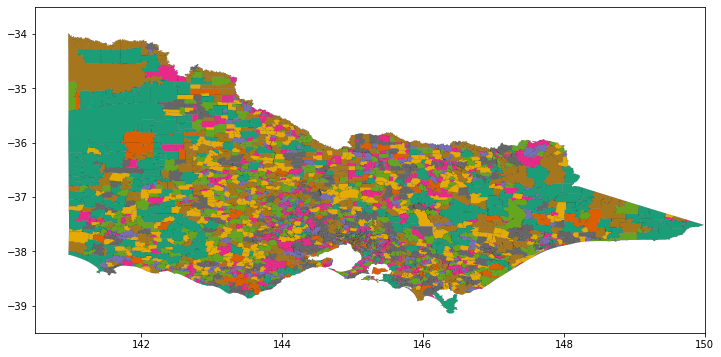

In [4]:
# Plotting polygons
# Colormaps
cm = matplotlib.cm.get_cmap('Dark2')

# Number of shapes
Nshp = len(shapes)
cccol = cm(1.*np.arange(Nshp)/Nshp) # one colour for every contry...
# plot
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
#Plot each country
for nshp in range(Nshp): # change range to xrange if you use Python 2
    ptchs   = [] # patches
    pts     = np.array(shapes[nshp].points) # points
    prt     = shapes[nshp].parts # parts
    par     = list(prt) + [pts.shape[0]]
        
    for pij in range(len(prt)): # change range to xrange if you use Python 2
         ptchs.append(Polygon(pts[par[pij]:par[pij+1]]))
    ax.add_collection(PatchCollection(ptchs,facecolor=cccol[nshp,:],edgecolor='k', linewidths=.1))
# setting limits of graph
ax.set_xlim(140.5,150)
ax.set_ylim(-39.5,-33.5)
plt.show()

## 1.5 Creating Columns
Now we proceed to create the columns for the final output

### 1.5a Column: Suburb
Suburbs are extracted using the given shapefile

In [5]:
suburb_lst = [] # initialize empty list
def suburb_create(lon, lat):
    '''Function to extract suburb of the given point using the shapefile'''
    point = Point(lon, lat) # create point of the passed coordinates
    # Iterating polygons
    for i in range(len(gdf.geometry)):
        # If point is within polygon
        if point.within(gdf.geometry[i]):
            # return suburb
            return gdf.VIC_LOCA_2[i].lower().title()
    return 'not available' # return default values

# extracting latitudes and longitudes from the csv
lats,longs = gp151['Lattitude'].tolist(),gp151['Longtitude'].tolist()
# iterating those points and passing through functions
for i in range(len(lats)):
    # appending suburb info to list
    suburb_lst += [suburb_create(longs[i], lats[i])]

In [6]:
# creating column for suburb using the newly created list
output_df['Suburb'] = suburb_lst

### 1.5b Columns : train_station_id, distance_to_train_station, travel_min_to_CBD

For the subsequent columns additional filtering is required which is performed in the cells below. Our approach involves taking the stop_times dataframe, filtering it based on the station requirements i.e. having trip ids running all week between 7 to 9:30 am. After filtering these values we pass it on to a function that returns the input station id and the minimum time to cbd. If no such path exists it returns none. Using those stations we find the nearest station and distance.

In [7]:
# concatinating dataframes for the GTFS folders
stop_times = pd.concat([metro_stop_times,regional_stop_times])
stops = pd.concat([metro_stops,regional_stops])
calendar = pd.concat([metro_calender,regional_calender])
total_trips = pd.concat([metro_trips,regional_trips])

In [8]:
# list containing ids for Southern Cross stations
scross_codes = stops[stops['stop_name'].str.contains('Southern Cross')]['stop_id'].tolist()

In [9]:
# List containing Service Ids for services that run all weekdays
weekday_service = calendar[calendar.loc[:,'monday':'friday'].sum(axis=1)==5].service_id.tolist()

In [10]:
# Custom function to turn date to int
# This is done for the purpose of filtering and sorting time columns
import re
def date_int(dt):
    '''Returns integer value of input time string'''
    dt = str(dt)
    dt = re.sub(':','',dt)
    return int(dt)

In [11]:
# Creating columns with integer time
stop_times['dtime'] = stop_times.departure_time.apply(lambda x: date_int(x))
# Extracting service ids from trip ids
stop_times['service_id'] = stop_times['trip_id'].str.extract(r'.*?\.(.*?)\.')

In [12]:
# Creating a filtered dataframe with services on all weekdays and departure after 7 am
filter_df = stop_times[(stop_times['service_id'].isin(weekday_service)) & (stop_times.dtime>=70000)].copy()

In [13]:
# Filter out trips with southern cross in them
trips = np.unique(filter_df[filter_df['stop_id'].isin(scross_codes)]['trip_id'].tolist())
# Filter out df based on this list
filter_df = filter_df[filter_df['trip_id'].isin(trips)]
# Filter out df based on departure time greater than 930 am
filter_df = filter_df[(filter_df.dtime<=93000) | (filter_df['stop_id'].isin(scross_codes))]

In [14]:
def str_t(strt):
    '''Function to convert integer date to string and vice versa using flag'''
    (h, m, s) = strt.split(':') # split time string
    result = float(h) * 3600 + float(m) * 60 + float(s) # convert to seconds
    return result
    
def min_cbd_calc(input_station):
    '''Function to calcuate minimum time from station to Southern Cross'''
    # list of trips using the station id
    current_trips = filter_df[filter_df['stop_id'] == input_station].trip_id.unique().tolist()
    timelist = [] # initialize list to store time for each trip
    if input_station in scross_codes: # if input station is Southern Cross give 0 
        return (0,input_station)
    # iterate trips
    for i in current_trips:
        # temporary list with station codes of southern cross and input station
        temp = [input_station] + scross_codes
        # slice based on temporary list
        tempslice = filter_df[(filter_df['trip_id'] == i) & (filter_df['stop_id'].isin(temp))]
        if len(tempslice) == 1: # if trip does not have southern cross, continue
            continue
        # create departure/arrival times for southern cross and input station
        t1 = tempslice[tempslice['stop_id']==input_station].iloc[0]['dtime']
        t2 = tempslice[tempslice['stop_id'].isin(scross_codes)].iloc[0]['dtime']
        # if train is going from southern cross to station, continue
        if t1>t2:
            continue
        # get actual time strings
        t1str = tempslice[tempslice['stop_id']==input_station].iloc[0]['departure_time']
        t2str = tempslice[tempslice['stop_id'].isin(scross_codes)].iloc[0]['departure_time']
        # append to timelist the difference in times
        timelist += [str_t(t2str)-str_t(t1str)]
    # calculate average
    if timelist == []:
        return (None,None)
    mintime = (sum(timelist)/len(timelist))/60
    return (mintime,input_station)

In [15]:
station_list, cbd_time_list = [],[] # initializing empty lists to store stations and time
# iterating all stations
for i in stops.stop_id:
    x = min_cbd_calc(i)
    if x!= None:
        # appending to list
        station_list += [x[1]]
        cbd_time_list += [x[0]]

In [16]:
# Filtering lists and removing None
station_list = [x for x in station_list if x is not None] 
cbd_time_list = [x for x in cbd_time_list if x is not None]

# Creating dictionary for stations with timing
cbdtimedict = dict(zip(station_list,cbd_time_list))

In [17]:
# filtering stations based on station ids extracted earlier
stations = stops[stops['stop_id'].isin(station_list)]
# resetting index for using keys iteratively
stations.reset_index(inplace=True)

In [18]:
def hdist(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6378 # Radius of earth in meters
    return c*r*1000

In [19]:
near_stat,near_stat_dist = [],[] # initializing empty lists
def near_station(lon, lat):
    '''Function to find closest station with direct trip to Southern Cross'''
    minlist, indexlist = [],[] # lists of indices and distance from station
    # iterating filtered station dataframe
    for i in range(len(stations)):
#         if min_cbd(stations['stop_id'][i]) is None:
            # appending to list
#             minlist += [np.inf]
        minlist += [hdist(lat,lon,stations.stop_lat[i],stations.stop_lon[i])]
    # finding minimum values using it getting index of the stop id
    retval = stations.stop_id[minlist.index(min(minlist))]
    # returning minimum distance and station id
    return (retval,min(minlist))

# building lists for columns of output dataframe
for i in range(len(lats)):
    # getting tuple result
    x = near_station(longs[i], lats[i])
    # unpacking tuple into lists
    near_stat += [x[0]]
    near_stat_dist += [x[1]]

In [20]:
# Creating new columns
output_df['train_station_id'] = near_stat
output_df['distance_to_train_station'] = near_stat_dist

In [21]:
# create the required column
output_df['travel_min_to_CBD'] = output_df['train_station_id'].apply(lambda x: cbdtimedict[x])

### 1.5c Column : over_priced?
For this particular column, instead of groupby we decided to create a new column with concatenated strings from all the needed columns. This creates a `psuedo composite key` for us to use in the filtering process. After filtering we extract the median and store it in a dictionary. Finally using **.apply** we create the column.

In [22]:
# Extract year
gp151['year'] = gp151['Date'].str.extract(r'.*?(\d{4})')

In [23]:
# Create new column with psuedo composite key
gp151['opc'] = gp151.Rooms.map(str) + gp151.Bathroom.map(str) + gp151.Car.map(str) + gp151.Type.map(str) + gp151.year.map(str)

In [24]:
medprice = [] # initialize list to store medians
opc = gp151['opc'].unique().tolist() # get unique values from the created key
# iterate the values
for i in opc:
    # append median price for each key
    medprice += [gp151[gp151['opc']==i].Price.median()]
medprice_dic = dict(zip(opc,medprice)) # create dictionary

In [25]:
# overprice functions
def overprice(price,median):
    '''Simple function to return boolean'''
    return price>median

In [26]:
# Create column using apply and invoking created function
gp151['over_priced?'] = gp151.apply(lambda row : overprice(row['Price'],medprice_dic[row['opc']]), axis = 1)

In [27]:
# adding column to output dataframe
output_df['over_priced?'] = gp151['over_priced?']

### 1.5d Columns: crime_A_average, crime_B_average, crime_C_average
Here our data has only entries for 2016 and 2017, however the code is designed to work for 3 years prior for the given years. The latter part involves matching suburb values with a created dictionary from the coucils file

In [28]:
# Extract type of crime 
crime['type'] = crime.apply (lambda row: row['CSA Offence Division'][:1], axis=1)

# Create a new dataframe for counting offence number 
local_area_df = crime.groupby(['Apr - Mar reference period','Local Government Area','type']).sum()["Offence Count"].reset_index(name='count')

# Create a dataframe for years in gp151 match count
df_crime = pd.DataFrame(columns=['Local Government Area','type','count','year'])

# For year exsists in gp151, count 3 prior years average
for year in (2016,2017):
    years = [ i+ year for i in [-1,-2,-3]]
    temp = local_area_df[local_area_df['Apr - Mar reference period'].isin(years)].groupby(['Local Government Area','type'])['count'].mean().reset_index(name='count')
    temp['year'] = str(year)
    df_crime = df_crime.append(temp,sort=False)

# Prepare local area dictionary  
councillist = [[row.split(':')[0],row.split(':')[1]] for row in council.splitlines()]
area_dic ={}
for row in councillist:
    sub = re.findall(r"'(.+?)'",row[1])
    for item in sub:
        area_dic[item] = row[0][:-1]

In [29]:
# Generate local area for each row
gp151['Local Government Area'] = output_df.apply(lambda row: area_dic[row['Suburb']], axis=1)
# Merge dataframe to generate crime A
gp151 = pd.merge(gp151, df_crime[['Local Government Area','year','count']][df_crime['type'] == 'A'], on = ['Local Government Area','year'], how = 'left')
gp151.rename(columns={'count':'crime_A_average'}, inplace=True)
# Merge dataframe to generate crime B
gp151 = pd.merge(gp151, df_crime[['Local Government Area','year','count']][df_crime['type'] == 'B'], on = ['Local Government Area','year'], how = 'left')
gp151.rename(columns={'count':'crime_B_average'}, inplace=True)
# Merge dataframe to generate crime C
gp151 = pd.merge(gp151, df_crime[['Local Government Area','year','count']][df_crime['type'] == 'C'], on = ['Local Government Area','year'], how = 'left')
gp151.rename(columns={'count':'crime_C_average'}, inplace=True)

In [30]:
# creating needed columns
output_df['crime_A_average'] = gp151['crime_A_average']
output_df['crime_B_average'] = gp151['crime_B_average']
output_df['crime_C_average'] = gp151['crime_C_average']

### 1.5e School related columns
Here we employ a class to scrape data from xml and store it as instance variables (such as type, latitude, longitude etc.). Then we split the data into primary and secondary schools and then proceed to work on it. This allows for neat and structured code.

In [31]:
# Prepare school class for school
class School():
    '''
    School class
    Stores information within the nexted xml tags for schools as instance variables
    Creates a School object which stores the information needed for this assignment
    '''
    def __init__(self, inputstring):
        self.school = inputstring
        self.name = self.name_get()
        self.school_type = self.schtype()
        self.lat = self.lat_get()
        self.lon = self.lon_get()

    def name_get(self):
        '''
        Returns name for the passed school
        '''
        name_re = re.compile('<school_name>(.*?)</school_name>')
        return re.search(name_re, self.school).group(1)
 
    def schtype(self):
        '''
        Returns the school type for the passed school
        '''
        schtype_re = re.compile('<school_type>(.+?)</school_type>')
        return re.search(schtype_re, self.school).group(1)
    
    def lat_get(self):
        '''
        Returns the latitude for the passed school
        '''
        lat_re = re.compile('<y>(.+?)</y>')
        return float(re.search(lat_re, self.school).group(1))
        
    def lon_get(self):
        '''
        Returns the Longitude for the passed school
        '''
        lon_re = re.compile('<x>(.+?)</x>')
        return float(re.search(lon_re, self.school).group(1))

In [32]:
# Pass xml file and find out each school data and create instance of the class
school_re = re.compile('<school>.*?</school>',flags=re.DOTALL)
school_list = re.findall(school_re, schoolxml)
school_list = [School(element) for element in school_list]

# Split school list by primary and secondary school 
pri_school = []
sec_school = []
for i in school_list:
    if i.school_type == 'Primary':
        pri_school.append(i)
    elif i.school_type == 'Secondary':
        sec_school.append(i)
    elif i.school_type == 'Pri/Sec':
        pri_school.append(i)
        sec_school.append(i)

In [33]:
# Extract each primary school data from html file 
pri_rank_re = re.compile('<tr class="row-.*?</tr>',flags=re.DOTALL)
pri_ranklist = re.findall(pri_rank_re, str(pri_schoolrank))
pri_ranklist = [ re.search(r'class="column-2">(.+?)<', row).group(1) for row in pri_ranklist]

# Extract each secondary school data from html file 
sec_rank_re = re.compile('<li>(.*?)</li>',flags=re.DOTALL)
sec_ranklist = re.findall(sec_rank_re, str(sec_schoolrank))
sec_ranklist = [ re.findall(r"<div>(.*?)</div>", row) for row in sec_ranklist]
sec_ranklist_n = [ row[0] for row in sec_ranklist]
sec_ranklist_r = [ int(row[1]) for row in sec_ranklist]

In [34]:
#Initial empty list
near_pri_school,near_pri_dist, near_sec_school, near_sec_dist, near_pri_rank, near_sec_rank = [],[],[],[],[],[]

# Prepare school distance function 
def near_school(lon, lat, schoollist):
    '''Function to calculate nearest school using haversine distance, same as nearest station'''
    minlist, indexlist = [],[] # initialize lists
    for i in range(len(schoollist)): 
        # append distance to distance list
        minlist += [hdist(lat,lon,schoollist[i].lat,schoollist[i].lon)]
    # return values of minimum distance and schoolname
    retval = schoollist[minlist.index(min(minlist))].name
    return (retval,min(minlist))

# Iterate every row 
for i in range(len(lats)):
    # invoke function
    x = near_school(longs[i], lats[i],pri_school)
    y = near_school(longs[i], lats[i],sec_school)
    # Using difflib to comparing
    z1 = difflib.get_close_matches(x[0], pri_ranklist, cutoff = 0.95)
    z2 = difflib.get_close_matches(y[0], sec_ranklist_n, cutoff = 0.86)
    # append ranks for primary schools
    if len(z1) != 0:
        near_pri_rank.append(pri_ranklist.index(z1[0]))
    else:
        near_pri_rank.append('not ranked') # default value
    # append ranks for secondary schools
    if len(z2) != 0:               
        near_sec_rank.append(sec_ranklist_r[sec_ranklist_n.index(z2[0])])
    else:
        near_sec_rank.append('not ranked') # default value
    # updating lists
    near_pri_school += [x[0]]
    near_pri_dist += [x[1]]
    near_sec_school += [y[0]]
    near_sec_dist += [y[1]]
    

In [35]:
# Creating needed columns
output_df['closest_primary_school'] = near_pri_school
output_df['distance_to_closest_primary'] = near_pri_dist
output_df['primary_school_ranking'] = near_pri_rank
output_df['closest_secondary_school'] = near_sec_school
output_df['distance_to_closest_secondary'] = near_sec_dist
output_df['secondary_school_ranking'] = near_sec_rank

In [36]:
gp151['trave_min_to_CBD'] = output_df.travel_min_to_CBD

In [37]:
cols = output_df.columns.tolist()
new_cols = []
new_cols = cols[:2] + [cols[12]] + [cols[4]] + [cols[3]] + [cols[5]] + [cols[2]] + cols[6:12] + cols[13:]
output_df = output_df[new_cols]
output_df = output_df.rename(columns={'Landsize': 'LandSize', 'Lattitude': 'Latitude','Longtitude':'Longitude'})

In [38]:
output_df.to_csv('Group151_solution.csv')

# 2. Task 2: Data Reshaping

In this task we employ different data normalization/standardization techniques to our the columns:

`Age, Rooms, travel_min_to_CBD, crime_C_average`

We hope to find the right standardization technique for these columns so as to make them meaningful when passed onto a model. Our efforts are directed towards removing the skew in these values in hopes to normalize them.

In [39]:
def plot_scale(att, tag):
    '''Takes in column name and creates plots based on the different standardization techniques'''
    # creating list of names for plots
    nametag = [att+'_' + i for i in ('zscore','minmax','power','log')] 
    pricetag = ['price'+'_' + i for i in ('zscore','minmax','power','log')]
    # usking standard scaler
    std_scale = preprocessing.StandardScaler().fit(gp151[['Price',   att]])
    df_std = std_scale.transform(gp151[['Price', att]]) # an array not a df
    # variables for min max
    minR = gp151[att].min()
    maxR = gp151[att].max()
    minP = gp151['Price'].min()
    maxP = gp151['Price'].max() 
    # creating standardizations/transformations
    gp151[pricetag[0]] = df_std[:,0]
    gp151[nametag[0]] = df_std[:,1] #
    gp151[pricetag[1]] = gp151.apply(lambda row: (row['Price'] - minP) / (maxP - minP) , axis = 1) 
    gp151[nametag[1]] = gp151.apply(lambda row: (row[att] - minR) / (maxR - minR) , axis = 1) 
    gp151[pricetag[2]] = gp151.apply(lambda row: (row['Price'])**2, axis = 1)
    gp151[nametag[2]] = gp151.apply(lambda row: (row[att])**2, axis = 1)
    gp151[pricetag[3]] = gp151.apply(lambda row: np.log(row['Price']), axis = 1)
    gp151[nametag[3]] = gp151.apply(lambda row: np.log(row[att]), axis = 1)
    
    # Plotting
    plt.scatter( gp151[att],gp151['Price'])
    plt.title('Before Scale')
    plt.xlabel(att)
    plt.ylabel('Price')
    plt.show()
    plt.scatter(gp151[nametag[tag]],gp151['Price'])
    plt.title('After')
    plt.ylabel('Price')
    plt.show()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


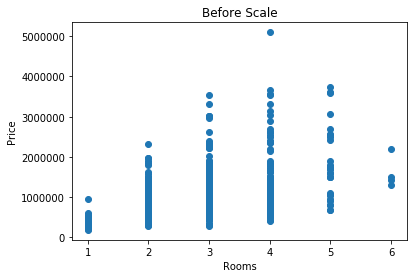

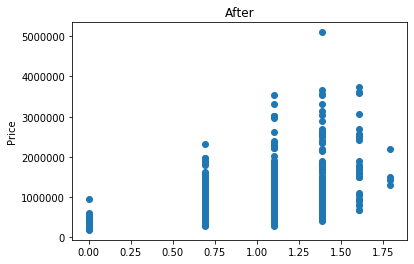

In [40]:
plot_scale('Rooms',3)

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log


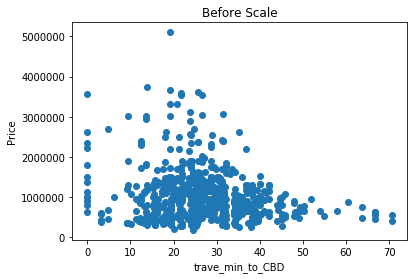

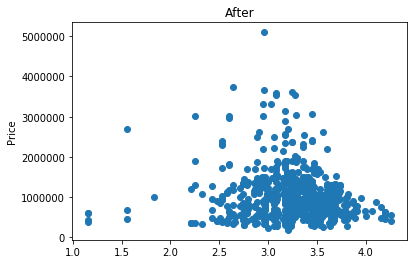

In [41]:
plot_scale('trave_min_to_CBD',3)

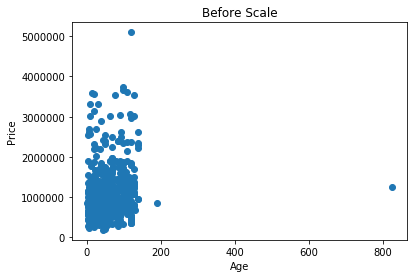

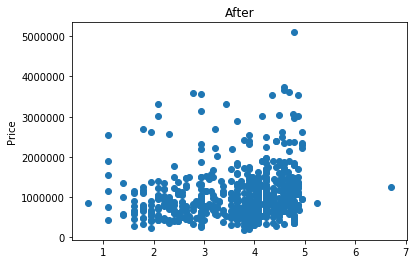

In [42]:
plot_scale('Age',3)

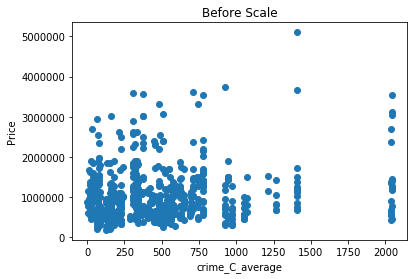

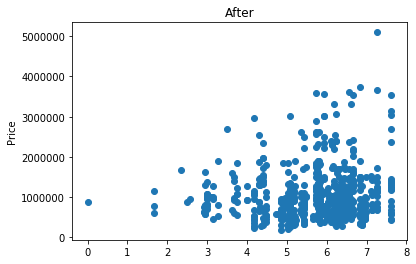

In [43]:
plot_scale('crime_C_average',3)

It is evident that most of the standardizations are not that effective, given our dataset. Minmax, Z-score and power scaling yeild a similar result if we consider the skewness of our data. For example, considering Rooms column it is clear that the values do not have much of a disparity as the range is small. Applying techniques here wont yeild any meaningful result. In these cases we still get data which has some skew associated with it. 

Only log scaling may result into something meaningful. Using log scaling we can see that most of the positive skew of the data will be effectively removed. Thus applying log scaling we can expect better results for our model. However, if a linear relationship between these variables exists it can be verified with a vector assembler and measuring the results against the training and testing datasets.

After scaling some of the obvious trends seem apparent. Such as the price of the property seems to vary with the age associated with it should be given the real world trends of real estate. Withouth log one cannot infer it so easily with the given plots.

### References

1. https://gis.stackexchange.com/questions/131716/plot-shapefile-with-matplotlib
2. https://stackoverflow.com/questions/7861196/check-if-a-geopoint-with-latitude-and-longitude-is-within-a-shapefile
3. https://developers.google.com/transit/gtfs/reference/#tripstxt